# XGBoost
(C) 2018 Dariusz Kajtoch

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import sys
sys.path.append('../')
from incentives import optimal_revenue

In [2]:
data = pd.read_csv('../data/train.csv')

In [3]:
X = data[[
          'perc_premium_paid_by_cash_credit', 
          'age_in_days', 
          'Income', 
          'Count_3-6_months_late', 
          'Count_6-12_months_late', 
          'Count_more_than_12_months_late', 
          'no_of_premiums_paid', 
#          'premium',
          'application_underwriting_score',
#          'sourcing_channel'
         ]]
#X['logIncome'] = np.log(data['Income'])
#X['logAge'] = np.log(data['age_in_days'])
#X['logperc_premium_paid_by_cash_credit'] = np.log(1. + data['perc_premium_paid_by_cash_credit'])
#X['standard_age'] = data['age_in_days'].apply(lambda row: np.floor(row/365.))
#X['perc'] = data['perc_premium_paid_by_cash_credit'].apply(lambda x: x if x<0.5 else x-1.)

#from scipy.stats import boxcox

#X['BCage_in_days'], _ = boxcox(data['age_in_days'])
#X['BCIncome'], _ = boxcox(data['Income'])

# fill nans
#for name in X.columns.tolist():
#    val = X[name].mean()#.iloc[0]
#    X[name].fillna(val, inplace=True)
    
# predictor
y = data['renewal']

# premium
premium = data['premium']

In [5]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

# max_depth = 5
# min_child_weight = 5
# colsample_bytree
# subsample
# gamma
# 

estimator = XGBClassifier(n_estimators=250,
                          reg_alpha=12.,
                          reg_lambda=0.,
                          random_state=654
                         )

# ----------------------
# Validate
# ----------------------

auc_tab  = np.array([])
loss_tab = np.array([])
revenue  = np.array([])

random_state = [245, 34, 78, 1234, 888]

for rstate in random_state:
    skf = StratifiedKFold(n_splits=10, random_state=rstate)
    
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        estimator.fit(X_train, y_train)
        prob = estimator.predict_proba(X_test)
        premium_test = premium.iloc[test_index]
    
        auc = roc_auc_score(y_test, prob[:,1])
        loss = log_loss(y_test, prob)
        net = np.array([optimal_revenue(premium_test.iloc[i], prob[i,1])[1] for i in range(0,len(prob))])
        net = np.sum(net)
    
        auc_tab  = np.append(auc_tab, auc)
        loss_tab = np.append(loss_tab, loss)
        revenue  = np.append(revenue, net)
    
        print('Single Fold done')
    print('---------------------')

Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
---------------------
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
---------------------
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
---------------------
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
---------------------
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
Single Fold done
---------------------


In [10]:
print('AUC: %.8f +/- %.8f' % (np.mean(auc_tab), np.std(auc_tab)))
print('Loss: %.8f +/- %.8f' % (np.mean(loss_tab), np.std(loss_tab)))
print('-------------------------------------------')
print(estimator.feature_importances_)

AUC: 0.84371698 +/- 0.00798831
Loss: 0.17879203 +/- 0.00332575
-------------------------------------------
[0.13638814 0.1773585  0.16981132 0.08948787 0.0819407  0.05714286
 0.10727762 0.180593  ]


1. reg_lambda = 12., n_estimators = 250
    * AUC: 0.84372250 +/- 0.00794011
    * Loss: 0.17877671 +/- 0.00332364
2. reg_lambda = 15., n_estimators = 250
    * AUC: 0.84347909 +/- 0.00775071
    * Loss: 0.17887990 +/- 0.00324139
3. reg_lambda = 12., n_estimators = 300
    * AUC: 0.84369098 +/- 0.00802754
    * Loss: 0.17880374 +/- 0.00334871
4. reg_lambda = 12., n_estimators = 270
    * AUC: 0.84371698 +/- 0.00798831
    * Loss: 0.17879203 +/- 0.00332575

In [6]:
print(auc_tab)
print(loss_tab)
print(revenue)

[0.84778787 0.84955196 0.83112891 0.85129575 0.85432661 0.83435097
 0.84538076 0.84850688 0.84317827 0.83166185 0.84778787 0.84955196
 0.83112891 0.85129575 0.85432661 0.83435097 0.84538076 0.84850688
 0.84317827 0.83166185 0.84778787 0.84955196 0.83112891 0.85129575
 0.85432661 0.83435097 0.84538076 0.84850688 0.84317827 0.83166185
 0.84778787 0.84955196 0.83112891 0.85129575 0.85432661 0.83435097
 0.84538076 0.84850688 0.84317827 0.83166185 0.84778787 0.84955196
 0.83112891 0.85129575 0.85432661 0.83435097 0.84538076 0.84850688
 0.84317827 0.83166185]
[0.1773638  0.17654094 0.18051359 0.17611909 0.17397765 0.18433642
 0.17826766 0.1760671  0.18060486 0.18412919 0.1773638  0.17654094
 0.18051359 0.17611909 0.17397765 0.18433642 0.17826766 0.1760671
 0.18060486 0.18412919 0.1773638  0.17654094 0.18051359 0.17611909
 0.17397765 0.18433642 0.17826766 0.1760671  0.18060486 0.18412919
 0.1773638  0.17654094 0.18051359 0.17611909 0.17397765 0.18433642
 0.17826766 0.1760671  0.18060486 0.184

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

plt.rcParams['text.usetex'] = True

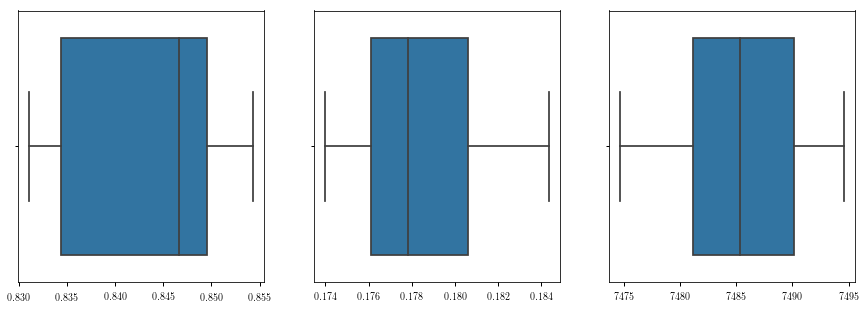

In [8]:
plt.close()

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3)

sns.boxplot(auc_tab, ax=ax[0])
sns.boxplot(loss_tab, ax=ax[1])
sns.boxplot(revenue, ax=ax[2])